## Imports

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy

from gwdetchar.io.datafind import get_data
from gwpy.timeseries import TimeSeries
from gwpy.timeseries import TimeSeriesDict
from scipy.interpolate import UnivariateSpline, interp1d

## Outlier removal functions

In [4]:
## Original outlier removal methods (z-score and n-percentile)

def find_outliers(ts, N=5, method='s'):
    """Find outliers within a `TimeSeries`

    Parameters
    ----------
    ts : `~gwpy.timeseries.TimeSeries`
        data to find outliers within

    N : `float`, optional
        if `method='s'`: number of standard deviations to consider an outlier
        if `method='pf'`: percentile range limit to consider an outlier
        default for both methods: 5
    method : `str`, optional
        outlier identification method to be used, must be `'s'` (standard
        deviation method) or `'pf'` (percentil range method)
        default: `'s'`

    Returns
    -------
    out : `ndarray`
        array indices of the input where outliers occur
    """
    if method == 'pf':
        ts = ts.value  # strip out Quantity extras
        quantile = numpy.quantile(ts, N)
        outliers = []
        for i, x in enumerate(ts):
            if x < quantile:
                outliers.append(i)
        return numpy.array(outliers)
    else:
        ts = ts.value  # strip out Quantity extras
        return numpy.nonzero(abs(ts - ts.mean()) > N*ts.std())[0]


def remove_outliers(ts, N=5, method='s'):
    """Find and remove outliers within a `TimeSeries`

    Parameters
    ----------
    ts : `~gwpy.timeseries.TimeSeries`
        data to find outliers within

    N : `float`, optional
        if `method='s'`: number of standard deviations to consider an outlier
        if `method='pf'`: percentile range limit to consider an outlier
        default for both methods: 5
    method : `str`, optional
        outlier identification method to be used, must be `'s'` (standard
        deviation method) or `'pf'` (percentil range method)
        default: `'s'`

    Notes
    -----
    This action is done in-place, with no `return` statement.
    """
    if method == 'pf':
        outliers = find_outliers(ts, N=N, method='pf')
        remove_by_idx(ts, outliers)
    else:
        outliers = find_outliers(ts, N=N, method='s')
        c = 1
        while outliers.any():
            print("-- Pass %d: removing %d outliers in %s" % (c, outliers.size, ts.name))
            cache = outliers
            remove_by_idx(ts, outliers)
            print("   Completed %d removal passes" % c)
            if numpy.array_equal(outliers, cache):
                print("   Outliers did not change, breaking recursion")
                break
            print("   %d outliers remain" % len(outliers))
            c += 1


def remove_by_idx(ts, indices, kind='linear'):
    """Remove elements within a `TimeSeries` by index

    Parameters
    ----------
    ts : `~gwpy.timeseries.TimeSeries`
        time series

    indices: `np.array(int)`
        indices at which outliers occur

    Notes
    -----
    This action is done to ts in-place, with no `return` statement.
    """
    print("Removing %d elements from time series and replacing via %s interpolation" % (len(indices), kind))
    mask = numpy.ones(ts.size, dtype=bool)
    mask[indices] = False
    x = numpy.arange(0, ts.size)[mask]
    y = ts.value[mask]
    # If endpoints are clipped by outlier removal, fill them back in with constant interpolation
    if 0 in indices:
        print("Left endpoint was clipped, filling back with constant interpolation")
        x = numpy.insert(x, 0, 0)
        y = numpy.insert(y, 0, y[0])
    if ts.size-1 in indices:
        print("Right endpoint was clipped, filling back with constant interpolation")
        x = numpy.append(x, ts.size)
        y = numpy.append(y, y[-1])
    interpolant = interp1d(x, y, kind=kind)
    ts[indices] = interpolant(indices) * ts.unit

In [10]:
## New outlier removal functions (LOF and TOF)

import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from uniqed.runners.tof_run import detect_outlier

def find_lof_outliers(ts, crit_lof=1.5, n_neighbors=20):
    """Find outliers within a `Timeseries` using LOF
       by considering the time series as 2D spatial data
       with time as a spatial dimension

    Parameters
    ----------
    ts : `~gwpy.timeseries.TimeSeries`
        data to find outliers within

    crit_lof: `float`, optional
        minimum LOF to consider a point an outlier
        default: 1.5
    
    n_neighbors: `int`, optional
        number of neighboring data points to consider when calculating LOF
        default: 20
    
    Returns
    -------
    out : `ndarray`
        array indices of the input where outliers occur
    """
    parser = get_lof_parser(ts, n_neighbors)
    is_outlier = parser.negative_outlier_factor_ < -crit_lof
    return numpy.arange(0, is_outlier.size)[is_outlier], -parser.negative_outlier_factor_


class WindowedLocalOutlierFactor(LocalOutlierFactor):
    def __init__(self, **kwargs):
        self._window = kwargs.get('window', 20)
        self._offset = kwargs.get('offset', 0.5)
        try:
            del kwargs['window']
            del kwargs['offset']
        except KeyError:
            pass
        super().__init__(**kwargs)

    def _get_rolling_windows(self, data):
        data_length = data.size
        offset = self._offset
        window = self._window
        offset_idx = int(offset*window)
        # Pad beginning and end of data using constant extrapolation
        if offset_idx > 0:
            data = numpy.insert(data, 0, numpy.full(offset_idx, data[0]))
        end_padding = window - offset_idx - 1
        if end_padding > 0:
            data = numpy.append(data, numpy.full(end_padding, data[-1]))
        # Stack offset data to make higher-dimensional embedding
        frames = [data[i:data_length+i] for i in range(window)]
        windows = numpy.stack(frames, axis=-1)
        return windows

    def fit(self, data, times=None):
        if times is not None and data.shape[0] != times.shape[0]:
            raise ValueError(
                f'Expected times {times.shape} to have the same number of entries as data {data.shape}')
        data = data.reshape(-1)
        windowed_data = self._get_rolling_windows(data)
        super().fit(windowed_data)

        
def find_lof_outliers_window(ts, crit_lof=1.5, n_neighbors=20, window=4):
    """Find outliers within a `Timeseries` using the LOF using a sliding window

    Parameters
    ----------
    ts : `~gwpy.timeseries.TimeSeries`
        data to find outliers within

    crit_lof: `float`, optional
        minimum LOF to consider a point an outlier
        default: 1.5
    
    n_neighbors: `int`, optional
        number of neighboring data points to consider when calculating LOF
        default: 20
        
    window: `int`, optional
        window size in number of data points
        default: 4
    
    Returns
    -------
    out : `ndarray`
        array indices of the input where outliers occur
    """
    parser = WindowedLocalOutlierFactor(window=window, n_neighbors=n_neighbors)
    parser.fit(ts.value)
    is_outlier = parser.negative_outlier_factor_ < -crit_lof
    return numpy.arange(0, is_outlier.size)[is_outlier], -parser.negative_outlier_factor_


def find_lof_quantile(ts, q=0.05, n_neighbors=20):
    """Find the lowest q-quantile of data sorted by LOF

    Parameters
    ----------
    ts : `~gwpy.timeseries.TimeSeries`
        data to find outliers within

    q: `float` between 0 and 1, optional
        q-quantile to remove
        default: 0.05
    
    n_neighbors: `int`, optional
        number of neighboring data points to consider when calculating LOF
        default: 20
    
    Returns
    -------
    out : `ndarray`
        array indices of the input where outliers occur
    """
    parser = get_lof_parser(ts, n_neighbors)
    indices = list(range(parser.negative_outlier_factor_.size))
    indices.sort(reverse=False, key=lambda i: parser.negative_outlier_factor_[i])
    quantile = int(q*parser.negative_outlier_factor_.size)
    return numpy.array(indices)[:quantile], -parser.negative_outlier_factor_

def get_lof_parser(ts, n_neighbors=20):
    """Generate a LocalOutlierFactor object fitted to data
       Transforms time series to 2D scatter plot with time interpreted
       as second spatial dimension

    Parameters
    ----------
    ts : `~gwpy.timeseries.TimeSeries`
        data to fit
        
    n_neighbors: `int`, optional
        number of neighboring data points to consider when calculating LOF
        default: 20
    
    Returns
    -------
    out : `LocalOutlierFactor`
        sklearn LocalOutlierFactor fitted to input time series
    """
    data = ts.value
    # transform to 2D scatter
    vrange = 8*(numpy.max(data) - numpy.min(data))
    xdata, xspacing = numpy.linspace(0, vrange, num=data.size, retstep=True)
    print('LOF x-spacing set to %f' % xspacing)
    data = numpy.stack((xdata, data), axis=-1)
    parser = LocalOutlierFactor(p=1, n_neighbors=n_neighbors)
    parser.fit_predict(data)
    return parser


def find_tof_outliers(ts, cutoff_n=5):
    """Find outliers within a `Timeseries` using the TOF metric

    Parameters
    ----------
    ts : `~gwpy.timeseries.TimeSeries`
        data to find outliers within

    cutoff_n: `int`, optional
        longest acceptable length of an anomalous event (# data points)
        default: 5
    
    Returns
    -------
    out : `ndarray`
        array indices of the input where outliers occur
    """
    time_series = pd.DataFrame(ts.value)
    res_df = detect_outlier(time_series, cutoff_n=cutoff_n)
    tofs = res_df['TOF_score'].to_numpy()
    print(tofs)
    return numpy.arange(0, tofs.size)[tofs < 1]


## Data fetching

/home/azimuth/.local/lib/python3.9/site-packages/gwpy/io/nds2.py:293: NDSWarning: Error authenticating against nds.ligo.caltech.edu:31200
  warnings.warn('Error authenticating against {0}:{1}'.format(host, port),


Please provide username for the LIGO.ORG kerberos realm: julian.ding
Password for julian.ding@LIGO.ORG: ········
Kerberos ticket generated for julian.ding@LIGO.ORG


/home/azimuth/.local/lib/python3.9/site-packages/gwpy/timeseries/io/nds2.py:122: UserWarning: Requested at least one minute trend, but start and stop GPS times are not multiples of 60. Times will be expanded outwards to compensate
  warnings.warn("Requested at least one minute trend, but "


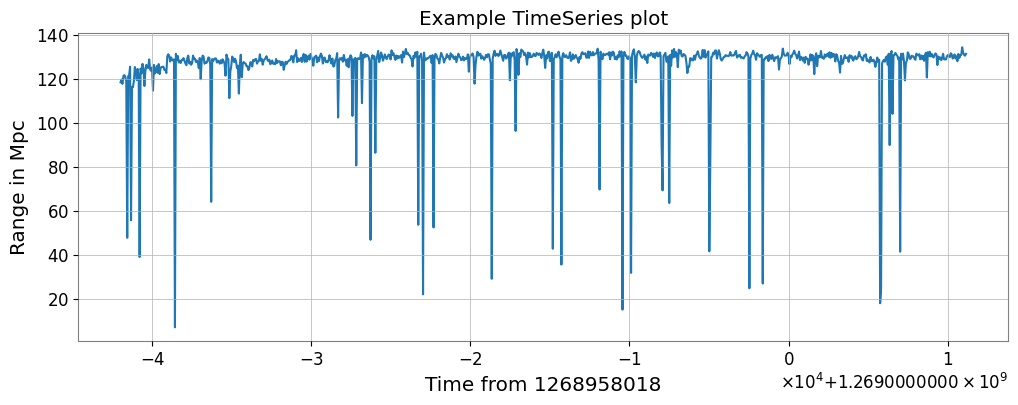

In [6]:
# For a single channel
channel = "L1:DMT-SNSW_EFFECTIVE_RANGE_MPC.mean"
gps_start = 1268958018
gps_end = 1269011267

ex_ts = TimeSeries.get(channel, gps_start, gps_end)
fig, ax = plt.subplots(figsize=[12,4])
ax.plot(ex_ts)
ax.set_title("Example TimeSeries plot")
ax.set_xlabel("Time from " + str(gps_start))
ax.set_ylabel("Range in Mpc")
fig.show()

## Outlier removal method comparisons

/home/azimuth/.local/lib/python3.9/site-packages/gwpy/timeseries/core.py:1149: NDSWarning: Low level daq error occured [26]: Requested data is on tape
  warnings.warn(error.split('\n', 1)[0],


The z-score method found outliers at: [ 102  147  161  162  196  298  309  348  350  446  509  567
  604  649  651  707  781  807  890  908  914  920  935  960
  979  994 1035 1037 1049 1090 1142 1174 1197 1254 1262]
-- Pass 1: removing 35 outliers in L1:DMT-SNSW_EFFECTIVE_RANGE_MPC.mean
Removing 35 elements from time series and replacing via linear interpolation
   Completed 1 removal passes
   Outliers did not change, breaking recursion


/home/azimuth/.local/lib/python3.9/site-packages/gwpy/timeseries/io/nds2.py:122: UserWarning: Requested at least one minute trend, but start and stop GPS times are not multiples of 60. Times will be expanded outwards to compensate
  warnings.warn("Requested at least one minute trend, but "
/home/azimuth/.local/lib/python3.9/site-packages/gwpy/timeseries/core.py:1149: NDSWarning: Low level daq error occured [26]: Requested data is on tape
  warnings.warn(error.split('\n', 1)[0],


The percentile method found outliers at: [  29   86  102  147  161  162  196  271  282  298  303  309
  348  350  361  446  461  470  509  514  567  604  607  616
  649  651  652  707  715  766  781  797  807  812  817  848
  855  866  890  908  914  918  920  935  947  960  979  994
 1027 1028 1035 1037 1049 1065 1090 1138 1142 1161 1162 1174
 1179 1197 1236 1237 1238 1240 1254 1262 1331 1333 1358 1364]
Removing 72 elements from time series and replacing via linear interpolation


/home/azimuth/.local/lib/python3.9/site-packages/gwpy/timeseries/io/nds2.py:122: UserWarning: Requested at least one minute trend, but start and stop GPS times are not multiples of 60. Times will be expanded outwards to compensate
  warnings.warn("Requested at least one minute trend, but "
/home/azimuth/.local/lib/python3.9/site-packages/gwpy/timeseries/core.py:1149: NDSWarning: Low level daq error occured [26]: Requested data is on tape
  warnings.warn(error.split('\n', 1)[0],


Removing 188 elements from time series and replacing via linear interpolation
Right endpoint was clipped, filling back with constant interpolation


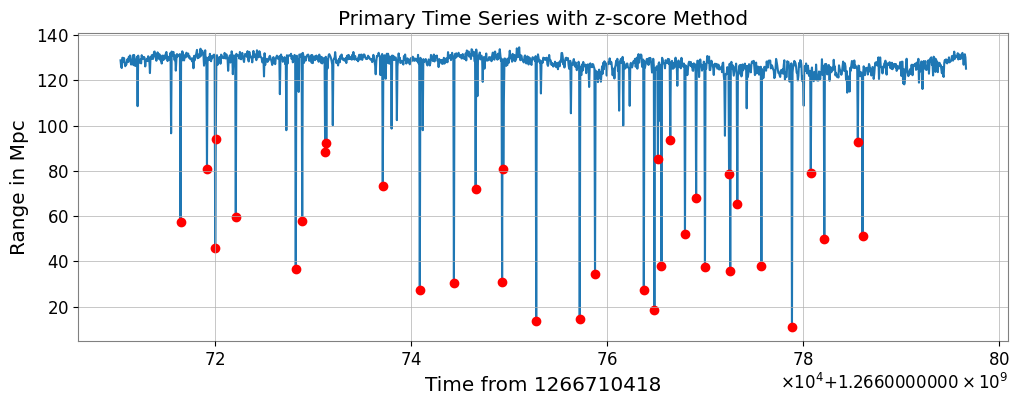

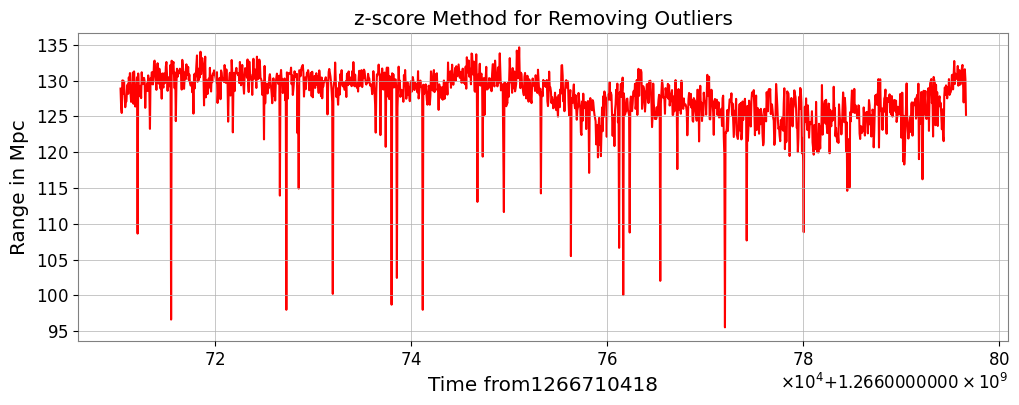

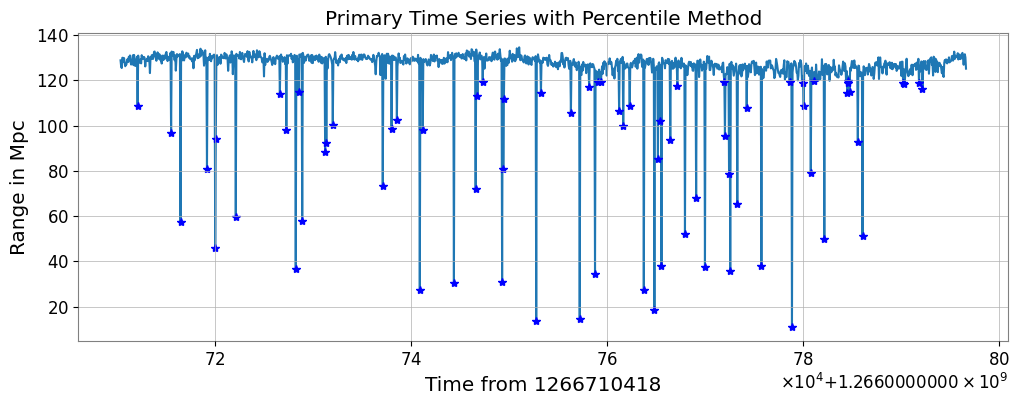

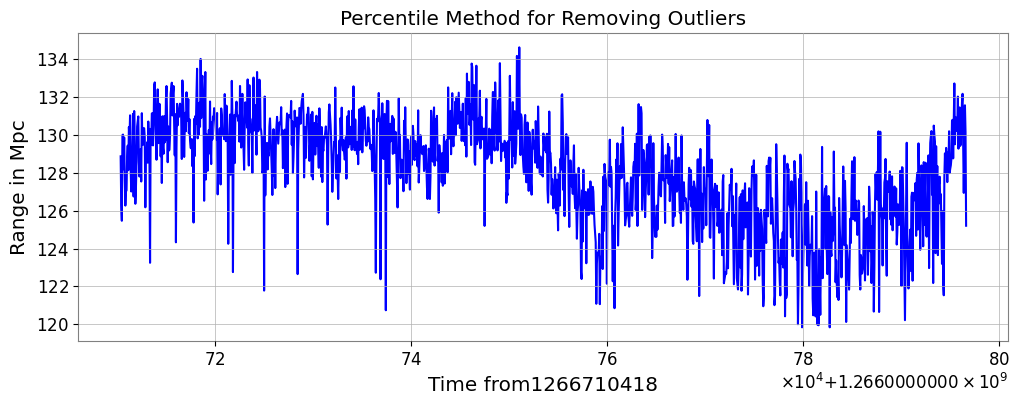

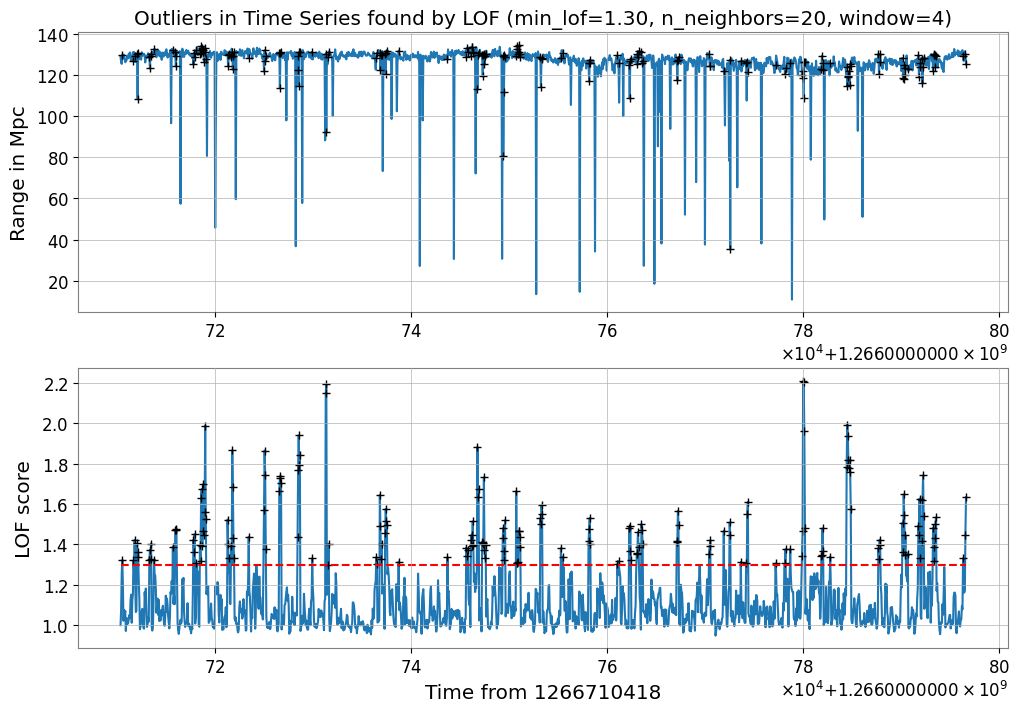

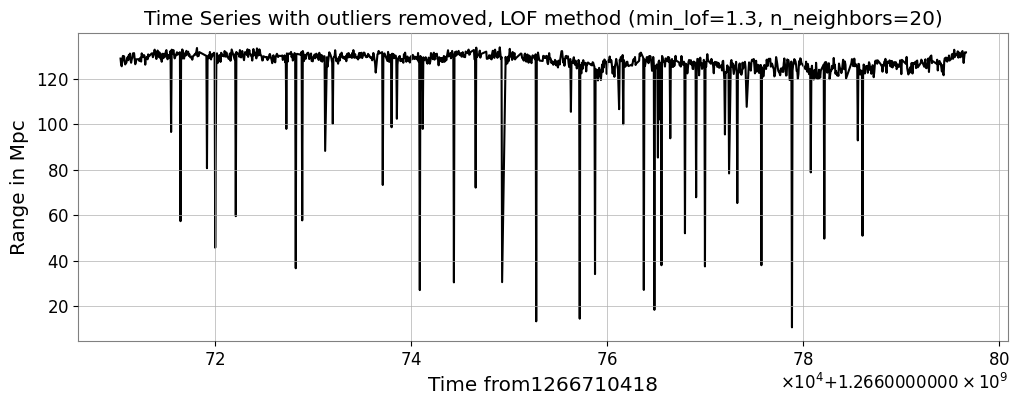

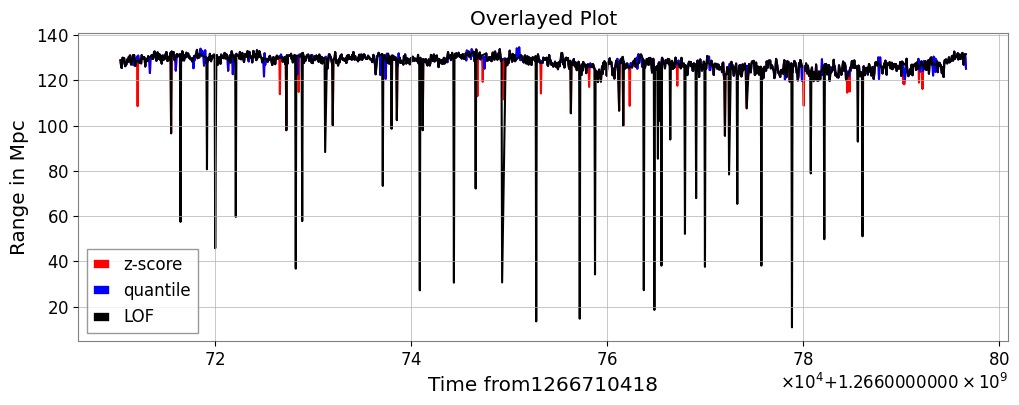

In [11]:
# Pulling data from channels to test the spline acting on outlier data in the range
channel = "L1:DMT-SNSW_EFFECTIVE_RANGE_MPC.mean"

# start and end represent the begining and end times (gps) that data is pulled from
# use tconvert(gps_time) to find the date

# start, end = (1268958018, 1269011267)
# start, end = (1264982418, 1265068758) # Feb 6, 2020 (seems to have gaps in data)
start, end = (1266710418, 1266796758) # Feb 26, 2020
# start, end = (1267315218, 1267401558) # Mar 4, 2020 (seems to have gaps in data)
# start, end = (1268956818, 1269043158) # Mar 23, 2020


# This will plot the unaltered data with the outliers found by the default method
# This method is supposed to run iteratively, more work would need to be done to see the progression of identified outliers
ts1 = TimeSeries.get(channel, start, end)
old = find_outliers(ts1, N=2.5, method='s')
print("The z-score method found outliers at:", old)
fig1, ax1 = plt.subplots(figsize=[12,4])
ax1.plot(ts1)
ax1.plot(ts1.times.value[old], ts1.value[old], 'ro')
ax1.set_title("Primary Time Series with z-score Method")
ax1.set_xlabel("Time from " + str(start))
ax1.set_ylabel("Range in Mpc")
fig1.show()

remove_outliers(ts1, N=2.5) #The default outlier removal now acts on ts1
fig3, ax3 = plt.subplots(figsize=[12,4])
ax3.plot(ts1, color='red')
ax3.set_title("z-score Method for Removing Outliers")
ax3.set_xlabel("Time from" + str(start))
ax3.set_ylabel("Range in Mpc")
fig3.show()

#This will plot the unaltered data with the outliers found by the percentile method in green stars
ts2 = TimeSeries.get(channel, start, end)
new = find_outliers(ts2, N=.05, method='pf')
print("The percentile method found outliers at:", new)
fig2, ax2 = plt.subplots(figsize=[12,4])
ax2.plot(ts2)
ax2.plot(ts2.times.value[new], ts2.value[new], 'b*')
ax2.set_title("Primary Time Series with Percentile Method")
ax2.set_xlabel("Time from " + str(start))
ax2.set_ylabel("Range in Mpc")
fig2.show()

remove_outliers(ts2, N=.05, method='pf') #The percentile outlier removal now acts on ts2
fig4, ax4 = plt.subplots(figsize=[12,4])
ax4.plot(ts2, color='blue')
ax4.set_title("Percentile Method for Removing Outliers")
ax4.set_xlabel("Time from" + str(start))
ax4.set_ylabel("Range in Mpc")
fig4.show()

# Basic LOF method
min_lof = 1.3
n_neighbors = 20
window=4
ts3 = TimeSeries.get(channel, start, end)
outliers, lofs = find_lof_outliers_window(ts3, min_lof, n_neighbors, window)
fig6, axs = plt.subplots(2, 1, figsize=[12,8])
axs[0].plot(ts3)
axs[0].plot(ts3.times.value[outliers], ts3.value[outliers], 'k+')
axs[0].set_title(
    "Outliers in Time Series found by LOF (min_lof=%.2f, n_neighbors=%d, window=%d)" % (min_lof, n_neighbors, window))
axs[0].set_ylabel("Range in Mpc")
axs[1].plot(ts3.times.value, lofs)
axs[1].plot(ts3.times.value[outliers], lofs[outliers], 'k+')
axs[1].plot([ts3.times.value[0], ts3.times.value[-1]], [min_lof, min_lof], 'r--')
axs[1].set_ylabel("LOF score")
axs[1].set_xlabel("Time from " + str(start))
fig6.show()

remove_by_idx(ts3, outliers)
fig7, ax7 = plt.subplots(figsize=[12,4])
ax7.plot(ts3, color='black')
ax7.set_title("Time Series with outliers removed, LOF method (min_lof=%.1f, n_neighbors=%d)" % (min_lof, n_neighbors))
ax7.set_xlabel("Time from" + str(start))
ax7.set_ylabel("Range in Mpc")
fig7.show()

#This plot overlays the TimeSeries for a direct comparison
fig5, ax5 = plt.subplots(figsize=[12,4])
ax5.plot(ts1, 'r', label='z-score')
ax5.plot(ts2, 'b', label='quantile')
ax5.plot(ts3, 'k', label='LOF')
ax5.set_title("Overlayed Plot")
ax5.set_xlabel("Time from" + str(start))
ax5.set_ylabel("Range in Mpc")
ax5.legend()
fig5.show()
#plt.savefig('./outlier_plots/Mar23_percentile_removal.png')

### LOF and TOF

In [ ]:
# LOF method

min_lof = 1.3
n_neighbors = 20
ts = TimeSeries.get(channel, start, end)
outliers = find_lof_outliers(ts, min_lof, n_neighbors)
fig1, ax1 = plt.subplots(figsize=[12,4])
ax1.plot(ts)
ax1.plot(ts.times.value[outliers], ts.value[outliers], 'r+')
ax1.set_title("Outliers in Time Series found by LOF (min_lof=%.1f, n_neighbors=%d)" % (min_lof, n_neighbors))
ax1.set_xlabel("Time from " + str(start))
ax1.set_ylabel("Range in Mpc")
fig1.show()

remove_by_idx(ts, outliers)
fig2, ax2 = plt.subplots(figsize=[12,4])
ax2.plot(ts, color='red')
ax2.set_title("Time Series with outliers removed, LOF method (min_lof=%.1f, n_neighbors=%d)" % (min_lof, n_neighbors))
ax2.set_xlabel("Time from" + str(start))
ax2.set_ylabel("Range in Mpc")
fig2.show()

In [ ]:
# LOF quantile method

q = 0.05
n_neighbors = 20
ts = TimeSeries.get(channel, start, end)
outliers = find_lof_quantile(ts, q, n_neighbors)
fig1, ax1 = plt.subplots(figsize=[12,4])
ax1.plot(ts)
ax1.plot(ts.times.value[outliers], ts.value[outliers], 'g+')
ax1.set_title("Outliers in Time Series found by LOF (q-quantile=%.2f, n_neighbors=%d)" % (q, n_neighbors))
ax1.set_xlabel("Time from " + str(start))
ax1.set_ylabel("Range in Mpc")
fig1.show()

remove_by_idx(ts, outliers)
fig2, ax2 = plt.subplots(figsize=[12,4])
ax2.plot(ts, color='green')
ax2.set_title("Time Series with outliers removed, LOF quantile method (q=%.2f, n_neighbors=%d)" % (q, n_neighbors))
ax2.set_xlabel("Time from" + str(start))
ax2.set_ylabel("Range in Mpc")
fig2.show()

/home/azimuth/.local/lib/python3.9/site-packages/gwpy/timeseries/io/nds2.py:122: UserWarning: Requested at least one minute trend, but start and stop GPS times are not multiples of 60. Times will be expanded outwards to compensate
  warnings.warn("Requested at least one minute trend, but "


[         nan 708.02100958  44.41283598 ... 655.68780681
 671.95982023          nan]
Removing 0 elements from time series and replacing via linear interpolation


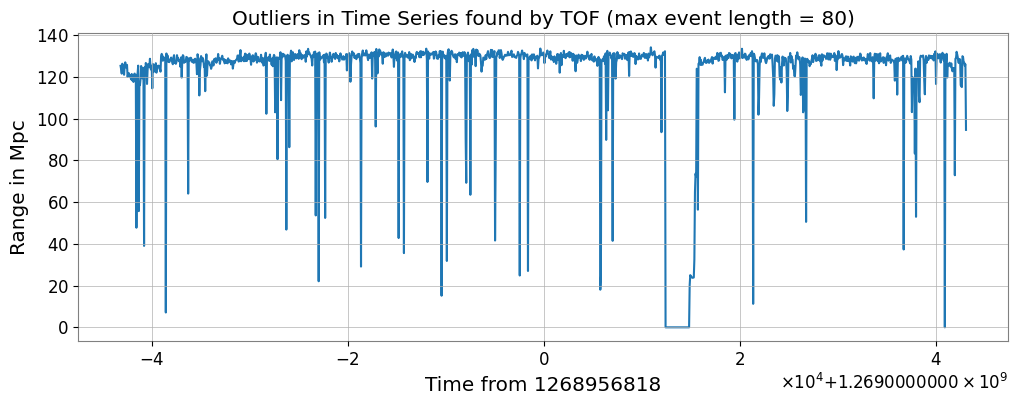

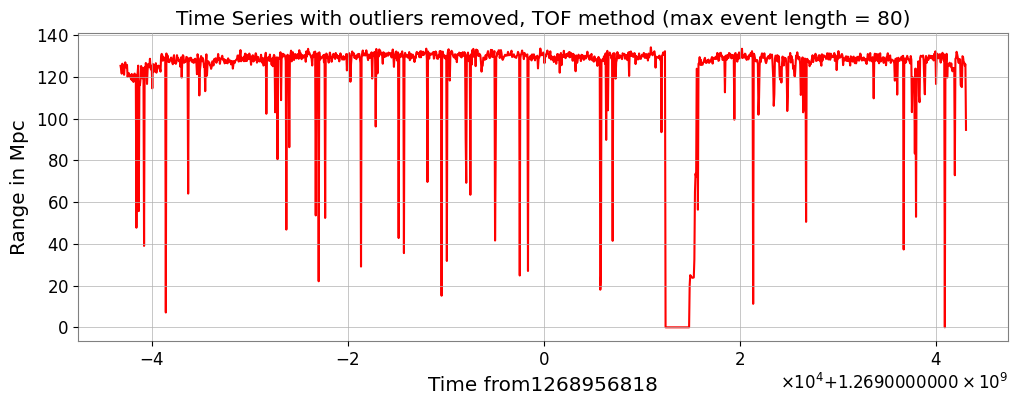

In [17]:
# TOF method

cutoff_n = 80
ts = TimeSeries.get(channel, start, end)
outliers = find_tof_outliers(ts, cutoff_n)
fig1, ax1 = plt.subplots(figsize=[12,4])
ax1.plot(ts)
ax1.plot(ts.times.value[outliers], ts.value[outliers], 'r*')
ax1.set_title("Outliers in Time Series found by TOF (max event length = %d)" % cutoff_n)
ax1.set_xlabel("Time from " + str(start))
ax1.set_ylabel("Range in Mpc")
fig1.show()

remove_by_idx(ts, outliers)
fig2, ax2 = plt.subplots(figsize=[12,4])
ax2.plot(ts, color='red')
ax2.set_title("Time Series with outliers removed, TOF method (max event length = %d)" % cutoff_n)
ax2.set_xlabel("Time from" + str(start))
ax2.set_ylabel("Range in Mpc")
fig2.show()